# Karras pre-conditioning

In [1]:
# !pip install k-diffusion seaborn

In [2]:
import timm, torch, random, datasets, math, fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import k_diffusion as K, torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from fastprogress import progress_bar
from diffusers import UNet2DModel, DDIMPipeline, DDPMPipeline, DDIMScheduler, DDPMScheduler

In [4]:
torch.set_printoptions(precision=5, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

In [5]:
xl,yl = 'image','label'
name = "fashion_mnist"
n_steps = 1000
bs = 512
dsd = load_dataset(name)

In [6]:
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs)

dl = dls.train
xb,yb = b = next(iter(dl))

In [7]:
# sig_data = xb.std()
sig_data = 0.66

`y` is clean signal, `n` is `N(0,1)` noise.

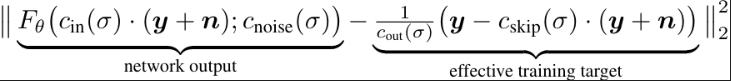

In [8]:
def scalings(sig):
    totvar = sig**2 + sig_data**2
    # c_skip,c_out,c_in
    return sig_data**2 / totvar, sig * sig_data / totvar.sqrt(), 1 / totvar.sqrt()

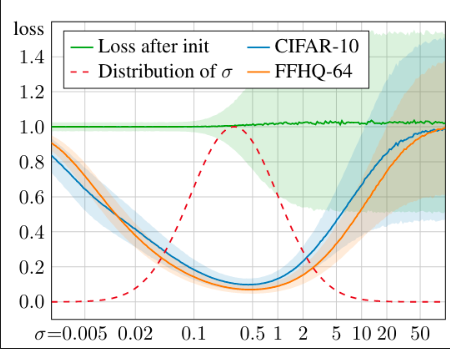

In [9]:
sig_samp = (torch.randn([10000]) * 1.2 - 1.2).exp()

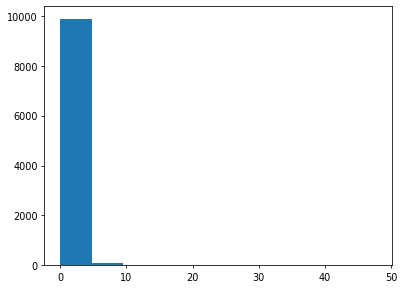

In [10]:
plt.hist(sig_samp);

In [11]:
import seaborn as sns

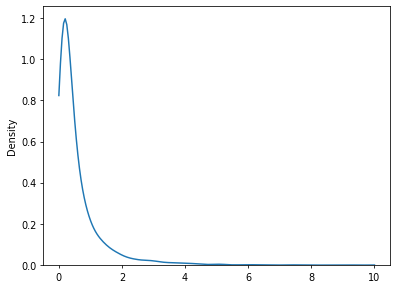

In [12]:
sns.kdeplot(sig_samp, clip=(0, 10));

In [13]:
def noisify(x0):
    device = x0.device
    sig = (torch.randn([len(x0)])*1.2-1.2).exp().to(x0).reshape(-1,1,1,1)
    noise = torch.randn_like(x0, device=device)
    c_skip,c_out,c_in = scalings(sig)
    noised_input = x0 + noise*sig
    target = (x0-c_skip*noised_input)/c_out
    return (noised_input*c_in,sig.squeeze()),target

In [14]:
def collate_ddpm(b): return noisify(default_collate(b)[xl])
def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=fc.defaults.cpus)

In [15]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [16]:
dl = dls.train
(noised_input,sig),target = b = next(iter(dl))

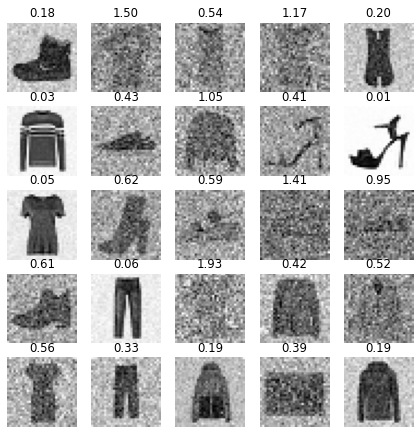

In [17]:
show_images(noised_input[:25], imsize=1.5, titles=fc.map_ex(sig[:25], '{:.02f}'))

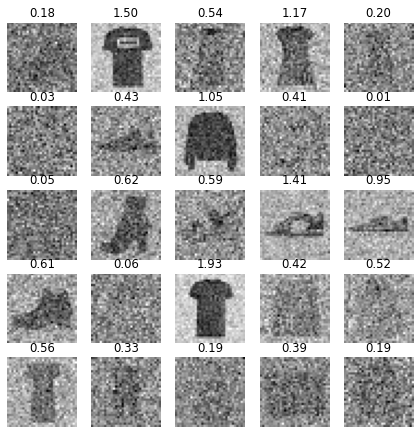

In [18]:
show_images(target[:25], imsize=1.5, titles=fc.map_ex(sig[:25], '{:.02f}'))

In [19]:
noised_input.mean(),noised_input.std(),target.mean(),target.std()

(tensor(-0.69019), tensor(1.01665), tensor(-0.40007), tensor(1.03293))

## Train

In [20]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [24]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [25]:
lr = 1e-3
epochs = 25
opt_func = partial(optim.Adam, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 256), norm_num_groups=8)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
1.021,0,train
0.842,0,eval
0.621,1,train
0.416,1,eval
0.322,2,train
0.258,2,eval
0.226,3,train
0.212,3,eval
0.201,4,train
0.233,4,eval


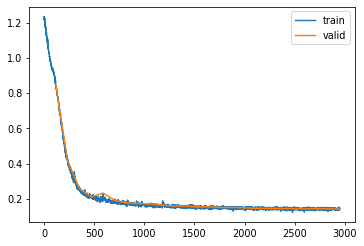

In [26]:
learn.fit(epochs)

In [27]:
torch.save(learn.model, '../models/fashion_karras.pkl')
# model = learn.model = torch.load('../models/fashion_karras.pkl').cuda()

loss,epoch,train
0.143,0,train
0.144,0,eval
0.144,1,train
0.145,1,eval
0.146,2,train
0.148,2,eval
0.148,3,train
0.151,3,eval
0.149,4,train
0.156,4,eval


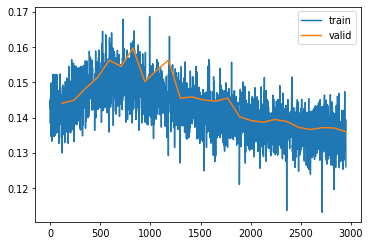

In [28]:
lr=1e-4
# learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)
learn.lr = lr
learn.fit(epochs)

In [29]:
torch.save(learn.model, '../models/fashion_karras.pkl')
# model = learn.model = torch.load('../models/fashion_karras.pkl').cuda()